In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_MOI2D, get_Pendulum_Invariance, get_SHM_Invariance, get_SHM2D_Invariance, get_Double_Pendulum_Invariance
from invariance_functions import degree_of_freedom, get_GPR_2Dmodel, get_SHM2D_data, evaluate_2Dmodel, get_double_pendulum_data
from local_invariance_kernels import  get_Polynomial_2D_Local_Invariance
from parameterised_invariance_kernels import get_Polynomial_2D_Invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [3]:
mean = zero_mean(4)

time_step = 0.1
training_time = 12
testing_time = 12

max_x = 60
n_train = 5
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5, (n_train))
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)

data = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch
test_data = get_double_pendulum_data(time_step, testing_time, 1e-8,[test_starting_position1],[test_starting_position2],[test_starting_velocity1],[test_starting_velocity2] )
for jitter in [1e-5]:
    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, 100)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
    print(evaluate_moi[:2])
    for invar_density in [8]: #np.arange(10, 30, 10):
            try:
                polynomial_degree = 4
#                kernel = get_Polynomial_2D_Local_Invariance(3, 40, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                kernel = get_Polynomial_2D_Invariance(3, invar_density, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                m = get_GPR_2Dmodel(kernel, mean, data, 100)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])
                print(kernel.f1_poly)
                print(kernel.f2_poly)
                print(kernel.g1_poly)
                print(kernel.g2_poly)

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 


[ 17.21132349 -59.3670237   48.4049024    9.94736783 -41.52485546]
[  5.15773615 -51.30631463 -16.60233227  29.32793593 -13.4806919 ]
[ 3.92259438  7.91912901 -6.30312193  2.34726986 -4.02064211]
[  0.09121787  10.59277579  -8.35908928  -1.01650558 -10.02151439]
27.020114262293845
-53.757819105308755
6.9834469305497535
-4.858091229693965
11727, 
(0.001679217037770129, 1.0233371142389096)
11882
(0.003966674741177496, 0.46430584075137626)
<Parameter: name=sigmoid, dtype=float64, shape=[70, 1], fn="sigmoid", numpy=
array([[-0.66283106],
       [-0.78990199],
       [ 0.75336739],
       [ 0.544097  ],
       [ 0.93127697],
       [-0.90181929],
       [ 0.97416663],
       [-0.89778613],
       [ 0.80649533],
       [ 0.97864685],
       [-0.15090375],
       [ 0.01332365],
       [ 0.96055342],
       [ 0.95110159],
       [ 0.14045768],
       [-0.94563275],
       [ 0.7541376 ],
       [-0.1024466 ],
       [-0.56623585],
       [-0.86102695],
       [ 0.12078894],
       [ 0.43360041]

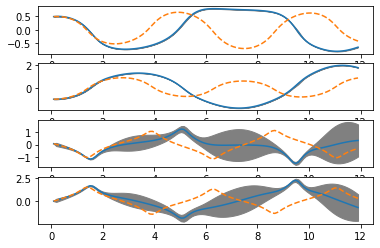

In [4]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[2][:,0])
axs[0].fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_moi[2][:,1])
axs[1].fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_moi[2][:,2])
axs[2].fill_between(t,evaluate_moi[2][:,2]+1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,2]-1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_moi[2][:,3])
axs[3].fill_between(t,evaluate_moi[2][:,3]+1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,3]-1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

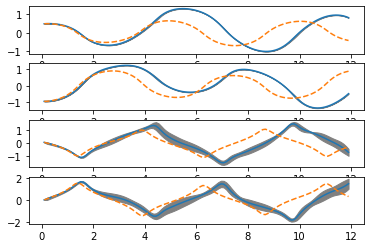

: 

In [5]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')